In [1]:

import torch
import triton
import triton.language as tl
from copy import deepcopy
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


# v1

In [2]:

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def rotate_half_v2(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, -x1), dim=-1)

def rotate_half_v3(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

@triton.jit
def _fused_apply_rope_fwd(X, X_R, X_EMBED, COS, SIN,
                        stride_xb, stride_xl, stride_xh, stride_xd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, H, D:tl.constexpr, BLOCK_H:  tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_l = pid % L
    x_offset = pid * stride_xl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    X += x_offset
    X_R += x_offset
    X_EMBED += x_offset
    COS += cos_offset
    SIN += cos_offset
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    x_ptrs = tl.make_block_ptr(
        base=X,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    xr_ptrs = tl.make_block_ptr(
        base=X_R,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    xembed_ptrs = tl.make_block_ptr(
        base=X_EMBED,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)
    x = tl.load(x_ptrs, boundary_check=(0,), padding_option='zero')
    xr = tl.load(xr_ptrs, boundary_check=(0,), padding_option='zero')
    x_embed = x * cos[None, :] + xr * sin[None, :]
    tl.store(xembed_ptrs, x_embed, boundary_check=(0,))

@triton.jit
def _fused_apply_rope_bwd(DX_EMBED, DX_EMBED_R, DX, COS, SIN,
                        stride_xb, stride_xl, stride_xh, stride_xd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, H, D:tl.constexpr, BLOCK_H:  tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_l = pid % L
    x_offset = pid * stride_xl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DX += x_offset
    DX_EMBED += x_offset
    DX_EMBED_R += x_offset
    COS += cos_offset
    SIN += cos_offset
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    dx_ptrs = tl.make_block_ptr(
        base=DX,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    dx_embed_r_ptrs = tl.make_block_ptr(
        base=DX_EMBED_R,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    dx_embed_ptrs = tl.make_block_ptr(
        base=DX_EMBED,
        shape=(H, D),
        offsets=(0, 0),
        strides=(stride_xh, stride_xd),
        block_shape=(BLOCK_H, D),
        order=(1,0)
    )
    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)
    dx_embed_r = tl.load(dx_embed_r_ptrs, boundary_check=(0,), padding_option='zero')
    dx_embed = tl.load(dx_embed_ptrs, boundary_check=(0,), padding_option='zero')
    dx = dx_embed * cos[None, :] + dx_embed_r * sin[None, :]
    tl.store(dx_ptrs, dx, boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        assert q.is_contiguous() and k.is_contiguous()
        qh = q.size(2)
        kh = k.size(2)
        x = torch.cat([q,k],axis=2)
        x_rotate_half = rotate_half(x)
        B, L, H, D = x.shape
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        BLOCK_H = triton.next_power_of_2(H)
        x_embed = torch.empty_like(x)
        num_warps=4
        num_stages=4
        M = B*L
        COS_B = cos.shape[0]
        _fused_apply_rope_fwd[(M,)](x, x_rotate_half, x_embed, cos, sin,
                        *x.stride(),
                        *cos.stride(),
                        B, COS_B, L, H,D, BLOCK_H,
                        num_warps=num_warps, num_stages=num_stages

        )
        q_embed, k_embed = x_embed.split([qh, kh], dim=2)
        q_embed = q_embed.contiguous().transpose(1,2)
        k_embed = k_embed.contiguous().transpose(1,2)

        ctx.save_for_backward(cos, sin)
        # ctx.infos = (B, H, L, D, BLOCK_H, M, COS_B, qh, kh)
        # ctx.num_warps = num_warps
        # ctx.num_stages = num_stages
        return q_embed, k_embed
    
    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        # dq_embed = dq_embed.transpose(1,2)
        # dk_embed = dk_embed.transpose(1,2)
        
        # B, H, L, D, BLOCK_H, M, COS_B, qh, kh = ctx.infos

        # cos,sin = ctx.saved_tensors
        # sin = rotate_half_v2(sin)
        # dx_embed = torch.cat([dq_embed, dk_embed], axis=-2)
        # dx_embed_r = rotate_half_v3(dx_embed)
        # dx = torch.empty_like(dx_embed)
        
        # _fused_apply_rope_bwd[(M,)](dx_embed, dx_embed_r, dx, cos, sin,
        #                 *dx_embed.stride(),
        #                 *cos.stride(),
        #                 B, COS_B, L, H,D, BLOCK_H,
        #                 num_warps=ctx.num_warps, num_stages=ctx.num_stages

        # )
        # dq, dk = dx.split([qh, kh], dim=2)
        # dq = dq.transpose(1,2).contiguous()
        # dk = dk.transpose(1,2).contiguous()


        cos,sin = ctx.saved_tensors
        cos = cos.unsqueeze(1)
        sin = sin.unsqueeze(1)
        dq = dq_embed * cos + rotate_half_v2(sin) * rotate_half_v3(dq_embed)
        dk = dk_embed * cos + rotate_half_v2(sin) * rotate_half_v3(dk_embed)
        return dq, dk, None, None


fused_apply_rope = _FusedApplyRope.apply



# v2

In [2]:

def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def rotate_half_v2(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, -x1), dim=-1)

def rotate_half_v3(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

@triton.jit
def _fused_apply_rope_fwd(Q, K, QR, KR, COS, SIN,
                          Q_EMBED, K_EMBED,
                          stride_qb, stride_qh, stride_ql, stride_qd,
                          stride_qrb, stride_qrh, stride_qrl, stride_qrd,
                          stride_cb, stride_cl, stride_cd,
                          B, COS_B, L, QH, KH, D:tl.constexpr
                          ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    q_offset = pid * stride_ql
    qr_offset = off_b * stride_qrb + off_l * stride_qrl
    factor = QH // KH
    k_offset = pid * stride_ql // factor
    kr_offset = off_b * stride_qrb // factor + off_l * stride_qrl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    Q += q_offset
    QR += qr_offset
    Q_EMBED += q_offset
    K += k_offset
    KR += kr_offset
    K_EMBED += k_offset
    COS += cos_offset
    SIN += cos_offset

    cols = tl.arange(0, D)
    q_ptrs = Q + cols
    qr_ptrs = QR + cols
    qembed_ptrs = Q_EMBED + cols
    k_ptrs = K + cols
    kr_ptrs = KR + cols
    kembed_ptrs = K_EMBED + cols
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)

    for idx in tl.range(0, QH):
        offset = D*idx
        offset_r = idx * stride_qrh
        q = tl.load(q_ptrs + offset)
        qr = tl.load(qr_ptrs + offset_r)
        q_embed = q * cos + qr * sin
        tl.store(qembed_ptrs + offset, q_embed)
        if idx % factor == 0:
            k = tl.load(k_ptrs + offset//factor)
            kr = tl.load(kr_ptrs + offset_r//factor)
            k_embed = k * cos + kr * sin
            tl.store(kembed_ptrs + offset//factor, k_embed)

    # for idx in tl.range(0, KH):
    #     offset = D*idx
    #     offset_r = idx * stride_qrh
    #     k = tl.load(k_ptrs + offset)
    #     kr = tl.load(kr_ptrs + offset_r)
    #     k_embed = k * cos + kr * sin
    #     tl.store(kembed_ptrs + offset, k_embed)

@triton.jit
def _fused_apply_rope_bwd(DQ_EMBED, DK_EMBED, DQ_EMBED_R, DK_EMBED_R, COS, SIN,
                          DQ, DK, 
                        stride_qb, stride_qh, stride_ql, stride_qd,
                        stride_kb, stride_kh, stride_kl, stride_kd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, QH, KH, D: tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    factor = QH // KH
    dq_offset = off_b * stride_qb + stride_ql * off_l
    dk_offset = off_b * stride_kb  + stride_kl * off_l
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DQ += dq_offset
    DQ_EMBED += dq_offset
    DQ_EMBED_R += dq_offset
    DK += dk_offset
    DK_EMBED += dk_offset
    DK_EMBED_R += dk_offset
    COS += cos_offset
    SIN += cos_offset

    cols = tl.arange(0, D)
    dq_ptrs = DQ + cols
    dq_embed_ptrs = DQ_EMBED + cols
    dq_embed_r_ptrs = DQ_EMBED_R + cols
    dk_ptrs = DK + cols
    dk_embed_ptrs = DK_EMBED + cols
    dk_embed_r_ptrs = DK_EMBED_R + cols
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)

    for idx in tl.range(0, QH):
        offset = stride_qh * idx
        dq_embed = tl.load(dq_embed_ptrs + offset)
        dq_embed_r = tl.load(dq_embed_r_ptrs + offset)
        dq = dq_embed * cos + dq_embed_r * sin
        tl.store(dq_ptrs + offset, dq)
        if idx % factor == 0:
            offset = idx * stride_kh // factor
            dk_embed = tl.load(dk_embed_ptrs + offset)
            dk_embed_r = tl.load(dk_embed_r_ptrs + offset)
            dk = dk_embed * cos + dk_embed_r * sin
            tl.store(dk_ptrs + offset, dk)

    # for idx in tl.range(0, KH):
    #     offset = idx * stride_kh
    #     dk_embed = tl.load(dk_embed_ptrs + offset)
    #     dk_embed_r = tl.load(dk_embed_r_ptrs + offset)
    #     dk = dk_embed * cos + dk_embed_r * sin
    #     tl.store(dk_ptrs + offset, dk)

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        assert q.transpose(1,2).is_contiguous()
        # print(q.stride(), k.stride())
        B, QH, L, D = q.shape
        KH = k.size(1)
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        num_stages=4
        num_warps=1

        qr = rotate_half(q)
        kr = rotate_half(k)
        # print(qr.stride())
        q_embed = torch.empty(B, L, QH, D, device=q.device, dtype=k.dtype)
        k_embed = torch.empty(B, L, KH, D, device=q.device, dtype=k.dtype)
        M = B*L
        COS_B = cos.shape[0]
        _fused_apply_rope_fwd[(M,)](q,k,qr,kr,cos, sin,
                                    q_embed, k_embed,
                                    *q.stride(),
                                    *qr.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D,
                                    num_warps=num_warps, num_stages=num_stages

        )

        ctx.save_for_backward(cos, sin)
        ctx.infos = (B, QH, KH, L, D, M, COS_B)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return q_embed.transpose(1,2), k_embed.transpose(1,2)

    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        # print(dq_embed.shape, dq_embed.stride())
        B, QH, KH, L, D, M, COS_B = ctx.infos
        cos,sin = ctx.saved_tensors
        dq = torch.empty_like(dq_embed)
        dk = torch.empty_like(dk_embed)
        dq_embed_r = rotate_half_v3(dq_embed)
        dk_embed_r = rotate_half_v3(dk_embed)
        sin = rotate_half_v2(sin)
        _fused_apply_rope_bwd[(M,)](dq_embed, dk_embed, dq_embed_r, dk_embed_r, cos, sin,
                                    dq, dk,
                                    *dq.stride(),
                                    *dk.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D,
                                    num_warps=ctx.num_warps, num_stages=ctx.num_stages
                                    )
        print(dq.stride(), dq_embed.stride(), dq_embed_r.stride())
        print(dk.stride(), dk_embed.stride(), dk_embed_r.stride())
        return dq, dk, None, None


fused_apply_rope = _FusedApplyRope.apply



# v3

In [ ]:
@triton.jit
def _fused_apply_rope_fwd(Q, K, QR, KR, COS, SIN,
                          Q_EMBED, K_EMBED,
                          stride_qb, stride_qh, stride_ql, stride_qd,
                          stride_qrb, stride_qrh, stride_qrl, stride_qrd,
                          stride_cb, stride_cl, stride_cd,
                          B, COS_B, L, QH, KH, D:tl.constexpr,BLOCK_QH:tl.constexpr, BLOCK_KH:tl.constexpr,
                          ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    q_offset = pid * stride_ql
    qr_offset = off_b * stride_qrb + off_l * stride_qrl
    factor = QH // KH
    k_offset = pid * stride_ql // factor
    kr_offset = off_b * stride_qrb // factor + off_l * stride_qrl
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    Q += q_offset
    QR += qr_offset
    Q_EMBED += q_offset
    K += k_offset
    KR += kr_offset
    K_EMBED += k_offset
    COS += cos_offset
    SIN += cos_offset
    q_block_ptrs = tl.make_block_ptr(
        base=Q,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    qr_block_ptrs = tl.make_block_ptr(
        base=QR,
        shape=(QH, D),
        strides=(stride_qrh, stride_qrd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    qembed_block_ptrs = tl.make_block_ptr(
        base=Q_EMBED,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    k_block_ptrs = tl.make_block_ptr(
        base=K,
        shape=(KH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    kr_block_ptrs = tl.make_block_ptr(
        base=KR,
        shape=(KH, D),
        strides=(stride_qrh, stride_qrd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    kembed_block_ptrs = tl.make_block_ptr(
        base=K_EMBED,
        shape=(KH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )

    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols
    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)

    q = tl.load(q_block_ptrs, boundary_check=(0,))
    qr = tl.load(qr_block_ptrs, boundary_check=(0,))
    q_embed = q * cos + qr * sin
    tl.store(qembed_block_ptrs, q_embed, boundary_check=(0,))
    k = tl.load(k_block_ptrs, boundary_check=(0,))
    kr = tl.load(kr_block_ptrs, boundary_check=(0,))
    k_embed = k * cos + kr * sin
    tl.store(kembed_block_ptrs, k_embed, boundary_check=(0,))


@triton.jit
def _fused_apply_rope_bwd(DQ_EMBED, DK_EMBED, DQ_EMBED_R, DK_EMBED_R, COS, SIN,
                          DQ, DK, 
                        stride_qb, stride_qh, stride_ql, stride_qd,
                        stride_qrb, stride_qrh, stride_qrl, stride_qrd,
                        stride_kb, stride_kh, stride_kl, stride_kd,
                        stride_cb, stride_cl, stride_cd,
                        B, COS_B, L, QH, KH, D: tl.constexpr, BLOCK_QH:tl.constexpr, BLOCK_KH:tl.constexpr,
                        ):
    pid = tl.program_id(0)
    off_b = pid // L
    off_l = pid % L
    dq_offset = off_b * stride_qb + stride_ql * off_l
    dqr_offset = off_b * stride_qrb + stride_qrl * off_l
    dk_offset = off_b * stride_kb  + stride_kl * off_l
    if B == COS_B:
        cos_offset = pid * stride_cl
    else:
        cos_offset = off_l * stride_cl
    # cos_offset = pid * stride_cl
    DQ += dq_offset
    DQ_EMBED += dq_offset
    DQ_EMBED_R += dqr_offset
    DK += dk_offset
    DK_EMBED += dk_offset
    DK_EMBED_R += dk_offset
    COS += cos_offset
    SIN += cos_offset

    dq_block_ptrs = tl.make_block_ptr(
        base=DQ,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    dq_embed_block_ptrs = tl.make_block_ptr(
        base=DQ_EMBED,
        shape=(QH, D),
        strides=(stride_qh, stride_qd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    dq_embed_r_block_ptrs = tl.make_block_ptr(
        base=DQ_EMBED_R,
        shape=(QH, D),
        strides=(stride_qrh, stride_qrd),
        offsets=(0,0),
        block_shape=(BLOCK_QH, D),
        order=(1,0)
    )
    dk_block_ptrs = tl.make_block_ptr(
        base=DK,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    dk_embed_block_ptrs = tl.make_block_ptr(
        base=DK_EMBED,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    dk_embed_r_block_ptrs = tl.make_block_ptr(
        base=DK_EMBED_R,
        shape=(KH, D),
        strides=(stride_kh, stride_kd),
        offsets=(0,0),
        block_shape=(BLOCK_KH, D),
        order=(1,0)
    )
    cols = tl.arange(0, D)
    cos_ptrs = COS + cols
    sin_ptrs = SIN + cols

    cos = tl.load(cos_ptrs)
    sin = tl.load(sin_ptrs)

    dq_embed = tl.load(dq_embed_block_ptrs, boundary_check=(0,))
    dq_embed_r = tl.load(dq_embed_r_block_ptrs, boundary_check=(0,))
    dq = dq_embed * cos + dq_embed_r * sin
    tl.store(dq_block_ptrs, dq, boundary_check=(0,))
    dk_embed = tl.load(dk_embed_block_ptrs, boundary_check=(0,))
    dk_embed_r = tl.load(dk_embed_r_block_ptrs, boundary_check=(0,))
    dk = dk_embed * cos + dk_embed_r * sin
    tl.store(dk_block_ptrs, dk, boundary_check=(0,))

class _FusedApplyRope(torch.autograd.Function):
    @staticmethod
    def forward(ctx, q, k, cos, sin):
        assert q.transpose(1,2).is_contiguous()
        # print(q.stride(), k.stride())
        B, QH, L, D = q.shape
        KH = k.size(1)
        assert (D % 32 == 0) or (D % 64 == 0) or (D % 128 == 0)
        num_stages=1
        num_warps=8

        qr = rotate_half(q)
        kr = rotate_half(k)
        # print(qr.stride())
        q_embed = torch.empty(B, L, QH, D, device=q.device, dtype=k.dtype)
        k_embed = torch.empty(B, L, KH, D, device=q.device, dtype=k.dtype)
        M = B*L
        COS_B = cos.shape[0]
        BLOCK_QH = triton.next_power_of_2(QH)
        BLOCK_KH = triton.next_power_of_2(KH)
        _fused_apply_rope_fwd[(M,)](q,k,qr,kr,cos, sin,
                                    q_embed, k_embed,
                                    *q.stride(),
                                    *qr.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D, BLOCK_QH, BLOCK_KH,
                                    num_warps=num_warps, num_stages=num_stages

        )

        ctx.save_for_backward(cos, sin)
        ctx.infos = (B, QH, KH, L, D, M, COS_B, BLOCK_QH, BLOCK_KH)
        ctx.num_warps = num_warps
        ctx.num_stages = num_stages
        return q_embed.transpose(1,2), k_embed.transpose(1,2)

    @staticmethod
    def backward(ctx, dq_embed, dk_embed):
        B, QH, KH, L, D, M, COS_B ,BLOCK_QH, BLOCK_KH= ctx.infos
        cos,sin = ctx.saved_tensors
        dq = torch.empty_like(dq_embed)
        dk = torch.empty_like(dk_embed)
        dq_embed_r = rotate_half_v3(dq_embed)
        dk_embed_r = rotate_half_v3(dk_embed)
        sin = rotate_half_v2(sin)
        _fused_apply_rope_bwd[(M,)](dq_embed, dk_embed, dq_embed_r, dk_embed_r, cos, sin,
                                    dq, dk,
                                    *dq.stride(),
                                    *dq_embed_r.stride(),
                                    *dk.stride(),
                                    *cos.stride(),
                                    B, COS_B, L, QH, KH, D, BLOCK_QH, BLOCK_KH,
                                    num_warps=ctx.num_warps, num_stages=ctx.num_stages
                                    )
        print(dq.stride(), dq_embed.stride(), dq_embed_r.stride())
        print(dk.stride(), dk_embed.stride(), dk_embed_r.stride())
        # 在模型中是：
        # 不连续，不连续，连续
        # 连续，连续，连续
        # 在这个测试代码中不太一样，都是连续的
        return dq, dk, None, None

fused_apply_rope = _FusedApplyRope.apply

# 精度测试

In [24]:
device = 'cuda'
dtype = torch.bfloat16
bs, seq_len, num_q_head, num_k_head, head_dim = 4, 128, 14, 2, 64
q1 = torch.randn(bs, seq_len, num_q_head, head_dim, device=device, dtype=dtype).transpose(1,2)
q1.requires_grad_(True)
k1  = torch.randn(bs, seq_len, num_k_head, head_dim,device=device, dtype=dtype).transpose(1,2)
k1.requires_grad_(True)
q2 = torch.randn(bs, seq_len, num_q_head, head_dim, device=device, dtype=dtype).transpose(1,2)
q2.data.copy_(q1.data)
q2.requires_grad_(True)
k2  = torch.randn(bs, seq_len, num_k_head, head_dim, device=device, dtype=dtype).transpose(1,2)
k2.data.copy_(k1.data)
k2.requires_grad_(True)
cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
sin = torch.randn_like(cos)


In [ ]:
if k1.grad is not None:
    k1.grad.zero_()
    q1.grad.zero_()
q_embed1, k_embed1 = apply_rotary_pos_emb(q1, k1, cos, sin)
# print(q_embed1.stride())
(q_embed1 @ repeat_kv(k_embed1, num_q_head//num_k_head).transpose(-1,-2)).sum().backward()

if k2.grad is not None:
    k2.grad.zero_()
    q2.grad.zero_()
q_embed2, k_embed2 = fused_apply_rope(q2, k2, cos, sin)
# print(q_embed2.stride())
(q_embed2 @ repeat_kv(k_embed2, num_q_head//num_k_head).transpose(-1,-2)).sum().backward()

print(torch.allclose(q_embed1, q_embed2, atol=1e-3), torch.allclose(k_embed1, k_embed2, atol=1e-3))
print(torch.allclose(q1.grad, q2.grad, atol=1e-3), torch.allclose(k1.grad, k2.grad, atol=1e-3))

(114688, 64, 896, 1)
(114688, 64, 896, 1)
(114688, 8192, 64, 1) (114688, 8192, 64, 1) (114688, 8192, 64, 1)
(16384, 8192, 64, 1) (16384, 8192, 64, 1) (16384, 8192, 64, 1)
True True
True True


In [7]:
q_embed1.stride()

(114688, 64, 896, 1)

In [ ]:
repeat_kv(k1, 2).stride()

(524288, 131072, 64, 1)

In [37]:
k1.grad.stride() == k2.grad.stride()

True

In [29]:
q_embed1.stride() == q_embed2.stride()

True

# forward

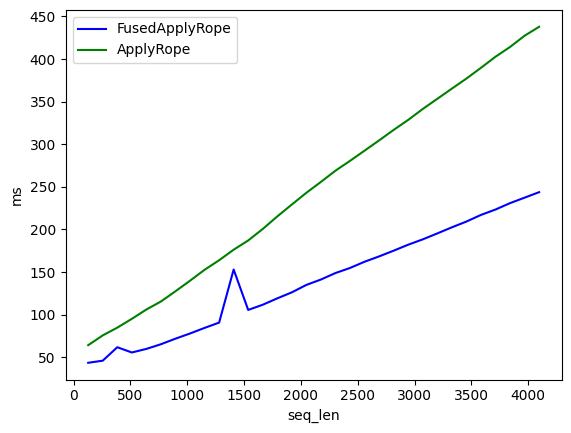

forward:
    seq_len  FusedApplyRope   ApplyRope
0     128.0       43.570980   64.206995
1     256.0       46.033353   75.705506
2     384.0       61.823316   84.801592
3     512.0       55.662315   95.123746
4     640.0       59.843127  106.077828
5     768.0       65.329276  115.477853
6     896.0       71.867742  127.471432
7    1024.0       77.925637  139.859140
8    1152.0       84.488049  152.662292
9    1280.0       90.701222  163.860619
10   1408.0      152.964279  176.244333
11   1536.0      105.581924  187.073708
12   1664.0      111.667246  200.567827
13   1792.0      119.159602  215.287209
14   1920.0      126.204804  229.250073
15   2048.0      134.929061  243.023589
16   2176.0      141.250104  255.792588
17   2304.0      148.855373  268.949360
18   2432.0      154.814377  280.486345
19   2560.0      162.116021  292.445600
20   2688.0      168.381572  304.482192
21   2816.0      175.108537  316.794783
22   2944.0      182.096139  328.529418
23   3072.0      188.367322  34

In [20]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':14, 'kh':2, 'head_dim': 128, 'bs': 2}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    if provider == 'FusedApplyRope':
        ms = triton.testing.do_bench(lambda: fused_apply_rope(q, k, cos, sin))
    if provider == 'ApplyRope':
        ms = triton.testing.do_bench(lambda: apply_rotary_pos_emb(q, k, cos, sin))

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# backward

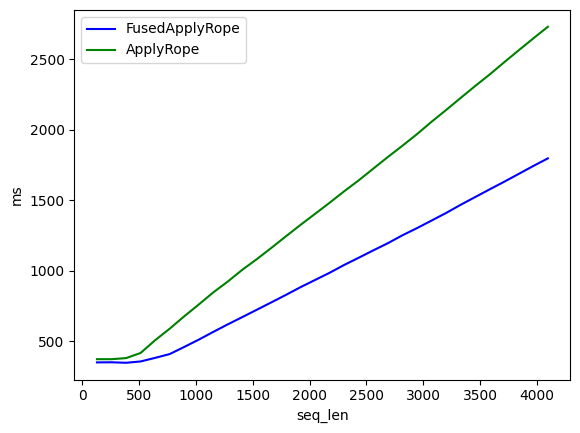

backward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0      348.326713   371.253073
1     256.0      349.254340   371.107310
2     384.0      345.631659   378.797174
3     512.0      355.005324   415.236324
4     640.0      380.459577   505.789518
5     768.0      407.492071   587.672651
6     896.0      457.985491   675.616860
7    1024.0      509.959221   759.528041
8    1152.0      565.108895   845.701814
9    1280.0      618.792772   923.118591
10   1408.0      670.465708  1006.689548
11   1536.0      722.735107  1082.283854
12   1664.0      775.152802  1162.434101
13   1792.0      828.205943  1244.483590
14   1920.0      882.928669  1325.459957
15   2048.0      933.995843  1403.667331
16   2176.0      985.007226  1482.570171
17   2304.0     1040.612698  1563.888311
18   2432.0     1091.774344  1641.554356
19   2560.0     1144.023061  1724.625230
20   2688.0     1194.894671  1807.237148
21   2816.0     1251.039028  1887.090564
22   2944.0     1301.836014  1969.205618
23   3

In [19]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':14, 'kh':2, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'FusedApplyRope':
        a,b = fused_apply_rope(q, k, cos, sin)
        loss = (a * repeat_kv(b, qh//kh)).sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        a,b = apply_rotary_pos_emb(q, k, cos, sin)
        loss = (a * repeat_kv(b, qh//kh)).sum()
        ms = triton.testing.do_bench(lambda: loss.backward(retain_graph=True), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


# forward + backward

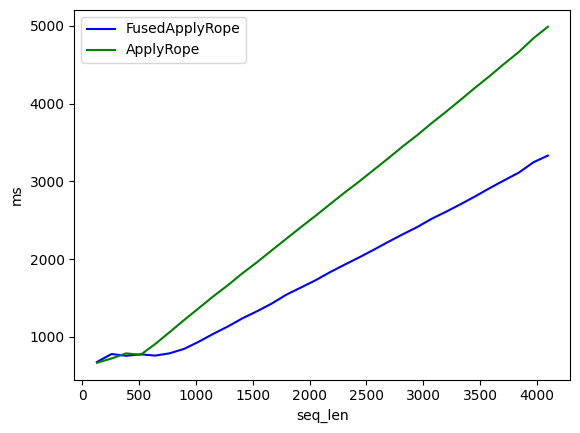

forward + backward:
    seq_len  FusedApplyRope    ApplyRope
0     128.0      676.982701   666.459858
1     256.0      778.941333   721.450388
2     384.0      756.401718   787.540019
3     512.0      775.393903   769.103229
4     640.0      758.812249   907.022655
5     768.0      788.472414  1061.235905
6     896.0      845.820725  1217.185378
7    1024.0      937.393248  1368.796468
8    1152.0     1038.949370  1521.073937
9    1280.0     1133.476734  1664.195061
10   1408.0     1238.043427  1817.280173
11   1536.0     1328.902245  1959.215045
12   1664.0     1426.020980  2109.777927
13   1792.0     1540.466309  2258.384705
14   1920.0     1632.397175  2407.636404
15   2048.0     1724.837661  2552.450895
16   2176.0     1829.212308  2702.632666
17   2304.0     1925.433636  2851.608038
18   2432.0     2019.467115  2993.604183
19   2560.0     2117.192984  3143.077374
20   2688.0     2218.734980  3291.909933
21   2816.0     2316.788912  3445.935249
22   2944.0     2410.383940  3591.243

In [10]:

torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['FusedApplyRope', 'ApplyRope'],  # possible values for `line_arg``
        line_names=[
            "FusedApplyRope",
            "ApplyRope",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward + backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'qh':14, 'kh':2, 'head_dim': 128, 'bs': 8}
        # args={'bs': 2, 'num_head': 32, 'rope_head_dim': 32, 
        #       'nope_head_dim': 64, 'kv_lora_rank': 256},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(bs, seq_len, head_dim,qh, kh, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    q = torch.randn(bs, seq_len, qh, head_dim, device=device, dtype=dtype).transpose(1,2)
    k = torch.randn(bs, seq_len, kh, head_dim, device=device, dtype=dtype).transpose(1,2)
    q.requires_grad_(True)
    k.requires_grad_(True)
    cos = torch.randn(bs, seq_len, head_dim, device=device, dtype=dtype)
    sin = torch.randn_like(cos)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)

    def fwd_bwd(func, *args):
        a,b = func(*args)
        loss = (a * repeat_kv(b, qh//kh)).sum()
        loss.backward(retain_graph=True)

    if provider == 'FusedApplyRope':
        ms = triton.testing.do_bench(lambda: fwd_bwd(fused_apply_rope, q, k, cos, sin), grad_to_none=[q,k])
    if provider == 'ApplyRope':
        ms = triton.testing.do_bench(lambda: fwd_bwd(apply_rotary_pos_emb, q, k, cos, sin), grad_to_none=[q,k])

    return ms * 1e3
# print(f'bs: {32}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


In [2]:
2.17/1.82

1.1923076923076923